In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import os
import warnings
warnings.filterwarnings("ignore")


In [17]:
# Step 1: Load the Iris dataset

file_path = "/content/drive/MyDrive/Data Science Projects/App/app/static/output_first_10000.csv"
data = pd.read_csv(file_path)
output_path = os.path.join("/content/drive/MyDrive/Data Science Projects/App/app/static")
os.makedirs(output_path, exist_ok=True)

In [18]:
# Step 2: Explore the data

print("Data Head:\n", data.head())
print("\nData Info:\n", data.info())
print("\nData Description:\n", data.describe())

Data Head:
    Unnamed: 0        ID Case Number                    Date  \
0           3  10508693    HZ250496  05/03/2016 11:40:00 PM   
1          89  10508695    HZ250409  05/03/2016 09:40:00 PM   
2         197  10508697    HZ250503  05/03/2016 11:31:00 PM   
3         673  10508698    HZ250424  05/03/2016 10:10:00 PM   
4         911  10508699    HZ250455  05/03/2016 10:00:00 PM   

                 Block  IUCR            Primary Type              Description  \
0   013XX S SAWYER AVE  0486                 BATTERY  DOMESTIC BATTERY SIMPLE   
1   061XX S DREXEL AVE  0486                 BATTERY  DOMESTIC BATTERY SIMPLE   
2  053XX W CHICAGO AVE  0470  PUBLIC PEACE VIOLATION         RECKLESS CONDUCT   
3    049XX W FULTON ST  0460                 BATTERY                   SIMPLE   
4    003XX N LOTUS AVE  0820                   THEFT           $500 AND UNDER   

  Location Description  Arrest  ...  Ward  Community Area  FBI Code  \
0            APARTMENT    True  ...  24.0          

In [19]:
# Step 3: Column details

print("\nColumn Details:")
for col in data.columns:
    print(f"Column: {col}, Type: {data[col].dtype}, Unique values: {data[col].nunique()}")



Column Details:
Column: Unnamed: 0, Type: int64, Unique values: 10000
Column: ID, Type: int64, Unique values: 10000
Column: Case Number, Type: object, Unique values: 9995
Column: Date, Type: object, Unique values: 5477
Column: Block, Type: object, Unique values: 6715
Column: IUCR, Type: object, Unique values: 209
Column: Primary Type, Type: object, Unique values: 28
Column: Description, Type: object, Unique values: 197
Column: Location Description, Type: object, Unique values: 95
Column: Arrest, Type: bool, Unique values: 2
Column: Domestic, Type: bool, Unique values: 2
Column: Beat, Type: int64, Unique values: 274
Column: District, Type: float64, Unique values: 22
Column: Ward, Type: float64, Unique values: 50
Column: Community Area, Type: float64, Unique values: 77
Column: FBI Code, Type: object, Unique values: 25
Column: X Coordinate, Type: float64, Unique values: 7624
Column: Y Coordinate, Type: float64, Unique values: 7875
Column: Year, Type: int64, Unique values: 5
Column: Updat

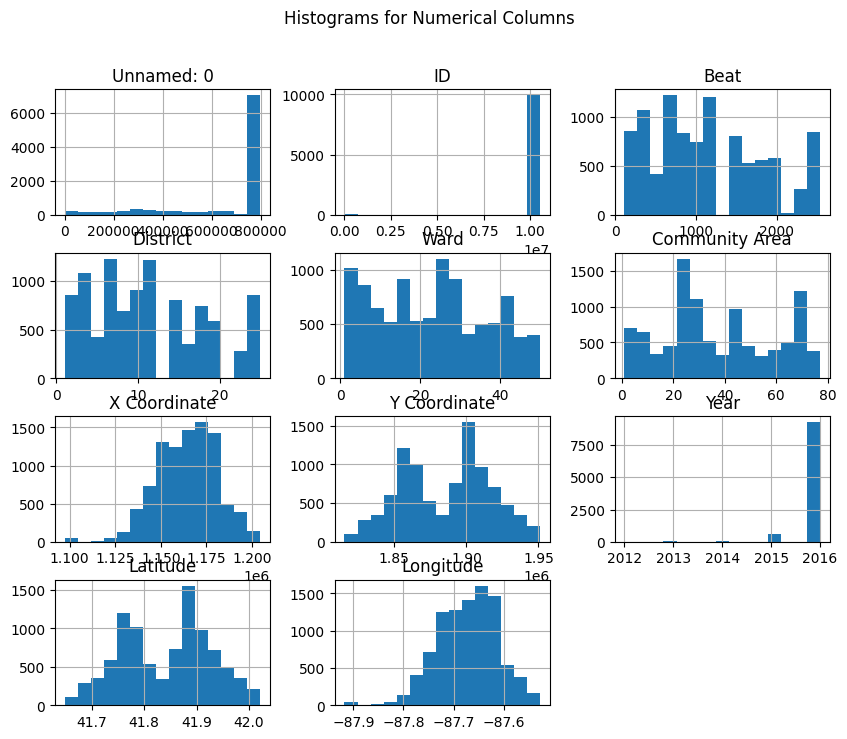

In [20]:
# Step 4: Visualize histograms for each numerical column

data.hist(bins=15, figsize=(10, 8))
plt.suptitle("Histograms for Numerical Columns")
# plt.show()
plt.savefig(os.path.join(output_path, "chicago_histograms.png"))


In [21]:
# Step 5: Handle missing values

# Display the number of missing values per column
print("Number of missing values in each column before filling:")
print(data.isnull().sum())

# Save the mean values for numerical columns with missing values
mean_values_with_na = data.mean(numeric_only=True)

# Save the mode values for categorical columns with missing values
mode_values_with_na = data.mode().iloc[0]


Number of missing values in each column before filling:
Unnamed: 0                0
ID                        0
Case Number               0
Date                      0
Block                     0
IUCR                      0
Primary Type              0
Description               0
Location Description     33
Arrest                    0
Domestic                  0
Beat                      0
District                  0
Ward                      0
Community Area            0
FBI Code                  0
X Coordinate            545
Y Coordinate            545
Year                      0
Updated On                0
Latitude                545
Longitude               545
Location                545
dtype: int64


In [22]:
# Fill missing values with the mean of numerical columns and mode of categorical columns
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if data[column].isnull().any():
            data[column].fillna(mode_values_with_na[column], inplace=True)
    else:  # Numerical columns
        if data[column].isnull().any():
            data[column].fillna(mean_values_with_na[column], inplace=True)


In [23]:
# Display the mean/mode values used to fill each column with missing values
print("\nValues used to fill columns with missing values:")
for column in data.columns:
    if data[column].dtype == 'object':  # Categorical columns
        if column in mode_values_with_na:
            print(f"{column}: {mode_values_with_na[column]}")
    else:  # Numerical columns
        if column in mean_values_with_na:
            print(f"{column}: {mean_values_with_na[column]}")



Values used to fill columns with missing values:
Unnamed: 0: 665109.3079
ID: 10446398.5458
Case Number: HZ140230
Date: 05/11/2016 05:00:00 PM
Block: 033XX W FILLMORE ST
IUCR: 0486
Primary Type: THEFT
Description: SIMPLE
Location Description: STREET
Arrest: 0.2485
Domestic: 0.1573
Beat: 1142.854
District: 11.1978
Ward: 22.8665
Community Area: 37.3771
FBI Code: 06
X Coordinate: 1164391.593442623
Y Coordinate: 1885795.3436277101
Year: 2015.9098
Updated On: 05/23/2016 03:48:54 PM
Latitude: 41.84222298964442
Longitude: -87.67226695446261
Location: (41.868180939, -87.709271389)


In [24]:
# Step 6: Identify and remove outliers using IQR (Interquartile Range)

# Identifying outliers for each numeric column
outlier_columns = []
outliers_dict = {}

# Iterate over each numeric column in the dataset
for feature in data.select_dtypes(include=[np.number]).columns:
    # Calculate Q1 (25th percentile), Q3 (75th percentile), and IQR (Interquartile Range)
    Q1 = data[feature].quantile(0.25)  # 25th percentile
    Q3 = data[feature].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile Range (difference between Q3 and Q1)

    # Identify outliers using the IQR rule: values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    outlier_mask = (data[feature] < (Q1 - 1.5 * IQR)) | (data[feature] > (Q3 + 1.5 * IQR))

    # If there are any outliers for this feature, store them in the outliers_dict
    if outlier_mask.any():  # If there is at least one outlier
        outliers_dict[feature] = data[outlier_mask]  # Store outliers in the dictionary
        outlier_columns.append(feature)  # Add the feature name to the outlier_columns list



Outliers Detected for Unnamed: 0:
      Unnamed: 0        ID Case Number                    Date  \
0              3  10508693    HZ250496  05/03/2016 11:40:00 PM   
1             89  10508695    HZ250409  05/03/2016 09:40:00 PM   
2            197  10508697    HZ250503  05/03/2016 11:31:00 PM   
3            673  10508698    HZ250424  05/03/2016 10:10:00 PM   
4            911  10508699    HZ250455  05/03/2016 10:00:00 PM   
...          ...       ...         ...                     ...   
1311      309267  10511463    HZ252479  05/05/2016 03:00:00 PM   
1312      309289  10511464    HZ252783  05/05/2016 12:01:00 AM   
1313      309463  10511467    HZ252787  05/05/2016 07:10:00 PM   
1314      310041  10511469    HZ252699  05/05/2016 08:00:00 AM   
1315      310170  10511470    HZ252596  05/05/2016 04:30:00 PM   

                     Block  IUCR            Primary Type  \
0       013XX S SAWYER AVE  0486                 BATTERY   
1       061XX S DREXEL AVE  0486                 BAT

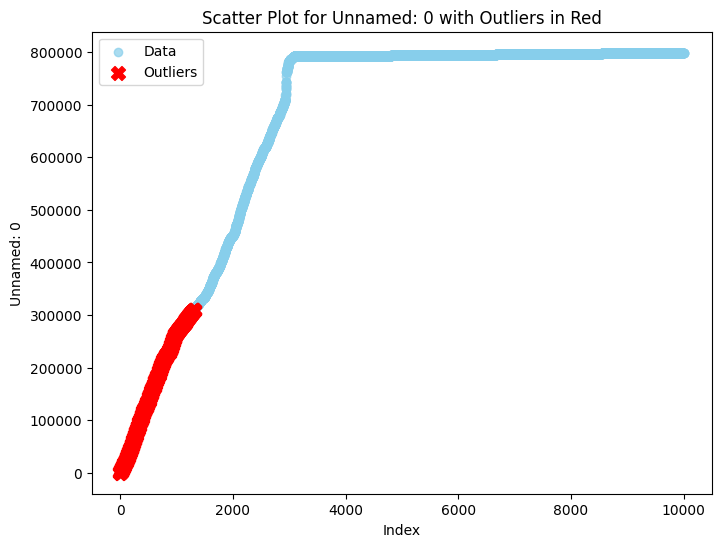

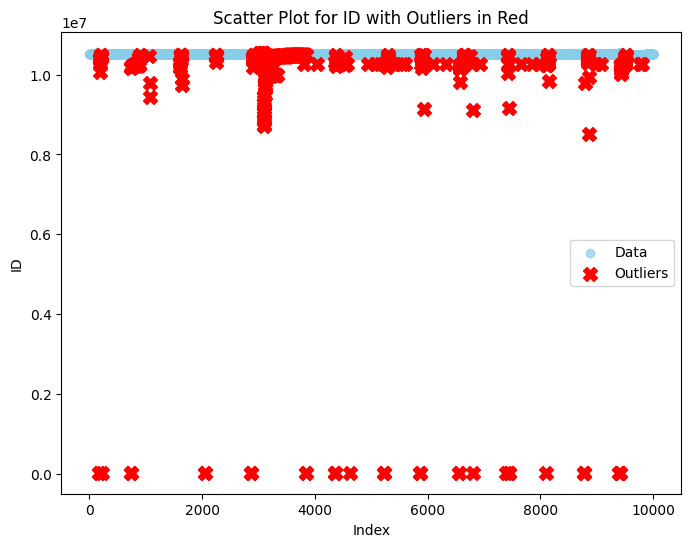

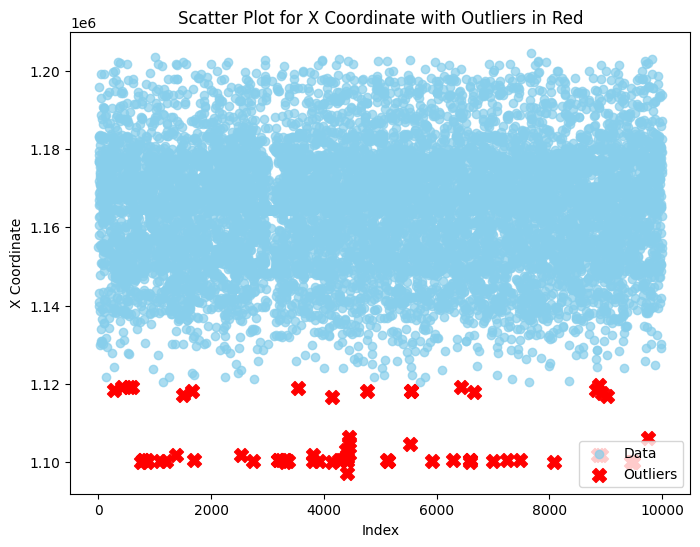

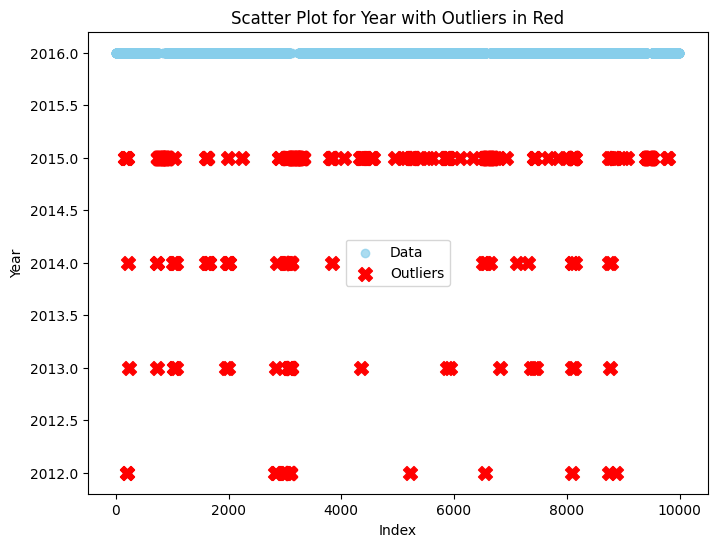

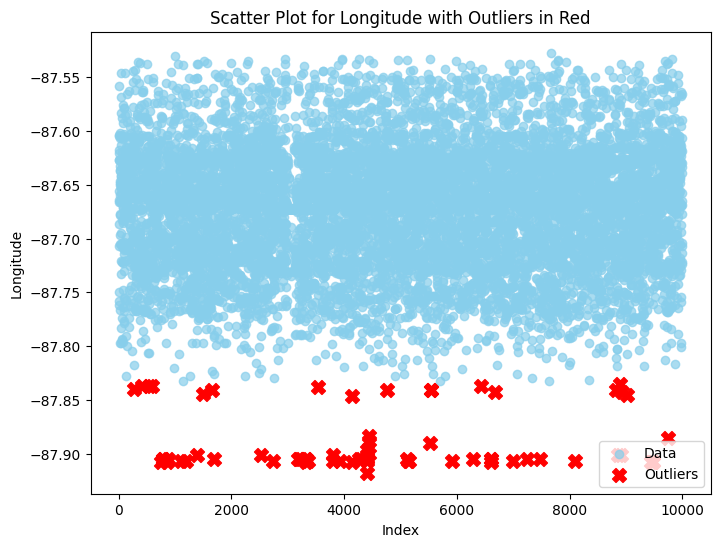

In [25]:
# Generate scatter plots only for the columns that contain outliers
for feature in outlier_columns:
    plt.figure(figsize=(8, 6))  # Create a figure for the scatter plot

    # Plot all data points (excluding outliers) for the feature
    non_outliers = data[~outlier_mask]  # Data without outliers
    plt.scatter(non_outliers.index, non_outliers[feature], color='skyblue', label="Data", alpha=0.7)

    # Plot the outliers in red
    outliers = outliers_dict[feature]  # Get the outliers for the current feature
    plt.scatter(outliers.index, outliers[feature], color='red', label="Outliers", s=100, marker='X')

    # Set title and labels for the plot
    plt.title(f"Scatter Plot for {feature} with Outliers in Red")
    plt.xlabel('Index')
    plt.ylabel(feature)
    plt.legend()
    # plt.show()
    plot_filename = f"chicago_scatter_{feature}.png"  # Use feature name in the file
    plt.savefig(os.path.join(output_path, plot_filename))

    # Print the outliers detected for the current feature
    print(f"\nOutliers Detected for {feature}:")
    print(outliers)

In [26]:
# Remove the outliers from the dataset

cleaned_data = data.copy()

# Loop through outlier columns to remove outliers
for feature in outlier_columns:
    outliers = outliers_dict[feature]  # Get outliers for the current feature
    cleaned_data

In [27]:
# Step 8: Preprocess the data

# Encode the target variable
label_encoder = LabelEncoder()
data['IUCR'] = label_encoder.fit_transform(data['IUCR'])

In [28]:
# Step 9: Handle non-numeric columns in X

# Convert categorical features to numeric using one-hot encoding or label encoding
# Here we use LabelEncoder for each categorical column (excluding the target 'IUCR')
for column in data.select_dtypes(include=['object']).columns:
    if column != 'IUCR':  # Avoid encoding the target variable
        label_encoder = LabelEncoder()
        data[column] = label_encoder.fit_transform(data[column])

# Step 10: Define features (X) and target (y)

X = data.drop(columns=['IUCR'])  # Features
y = data['IUCR']  # Target variable

In [29]:
# Step 11: Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [30]:
# Step 12: Feature scaling

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [31]:
# Step 12: Model selection and training

# Logistic Regression
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)

# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Step 13: Model evaluation

models = {
    "Logistic Regression": logistic_model,
    "Decision Tree": tree_model,
    "Random Forest": rf_model
}

In [33]:
# Step 14: Display metrics

# Initialize dictionaries for storing metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
conf_matrices = {}
class_reports = {}

# Calculate metrics for each model
for model_name, model in models.items():
    pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred, average="weighted")
    recall = recall_score(y_test, pred, average="weighted")
    f1 = f1_score(y_test, pred, average="weighted")

    # Append metric scores
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

    # Store confusion matrices and classification reports if needed
    conf_matrices[model_name] = confusion_matrix(y_test, pred)
    class_reports[model_name] = classification_report(y_test, pred)


In [34]:
# Creating the DataFrame with the metrics
metrics_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy": accuracy_scores,
    "Precision": precision_scores,
    "Recall": recall_scores,
    "F1 Score": f1_scores
})

# Melt the DataFrame for easier plotting with Seaborn
metrics_melted = metrics_df.melt(id_vars="Model", var_name="Metric", value_name="Score")


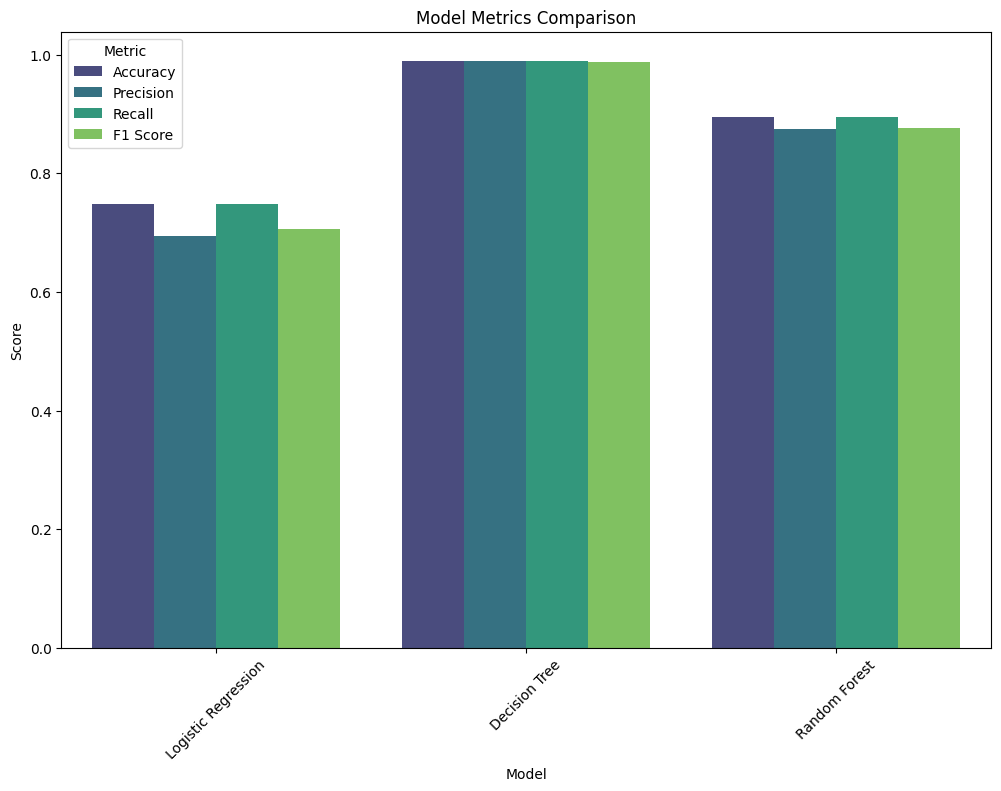

In [35]:
# Plotting the metrics
plt.figure(figsize=(12, 8))
sns.barplot(data=metrics_melted, x="Model", y="Score", hue="Metric", palette="viridis")
plt.title("Model Metrics Comparison")
plt.xlabel("Model")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")
# plt.show()
plt.savefig(os.path.join(output_path, "chicago_metrics.png"))



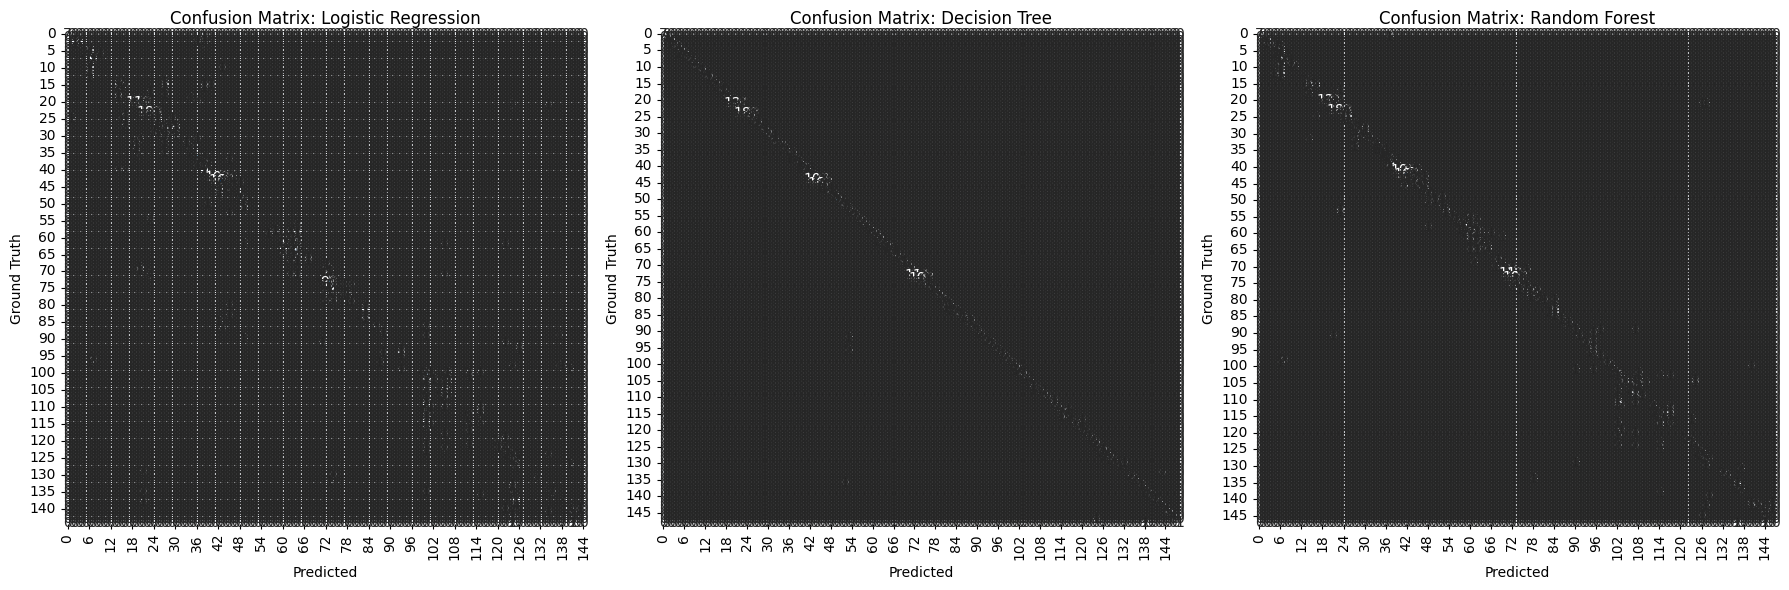

In [36]:
# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for i, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], cbar=False)
    axes[i].set_title(f"Confusion Matrix: {model_name}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Ground Truth")

plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(output_path, "chicago_metrix.png"))


In [37]:

# Display classification reports
for model_name, report in class_reports.items():
    print(f"\nClassification Report for {model_name}:\n{report}")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           3       0.00      0.00      0.00         1
           4       0.50      0.25      0.33         4
           6       0.75      0.55      0.63        11
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         3
          10       0.57      0.96      0.72        28
          12       0.83      1.00      0.90        19
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         5
          18       0.00      0.00      0.00         1
          19       0.00      0.00      0.00         4
          20       0.00      0.00      0.00         1
          21       0.44      0.92      0.60        13
          22       0.00      0.00      0.00         8
          23       0.00      0.00